# Differential Peak Shape Analysis

**Created**: 27 April 2022

## Environment

In [340]:
import collections
import os

import numpy as np
import pandas as pd
import pyBigWig
import matplotlib.pyplot as plt
from matplotlib import gridspec

## Load Data

In [2]:
ds_peaks = pd.read_csv('/nfs/users/nfs_n/nm18/gains_team282/epigenetics/regulation/immune/ds_peaks.csv')

In [3]:
ds_peaks.head()

,Cell.Type,Peak.ID,Peak.Chr,Peak.Start,Peak.End,logFC,AveExpr,t,P.Value,adj.P.Val,B
0,Monocytes,20:1621268-1621665,20,1621268,1621665,-0.467576,0.000649,-12.257109,9.291093e-23,2.755506e-17,41.137709
1,Monocytes,12:109845022-109847993,12,109845022,109847993,-0.021104,-0.004394,-10.515470,1.235845e-18,1.832604e-13,31.706296
2,Monocytes,2:156331680-156333649,2,156331680,156333649,-0.025283,-0.011734,-10.349613,3.060158e-18,3.025221e-13,30.806342
3,Monocytes,17:28727663-28729453,17,28727663,28729453,-0.017255,0.013492,-9.550207,2.394571e-16,1.775425e-11,26.481373
4,Monocytes,10:132570571-132572954,10,132570571,132572954,0.016830,-0.011966,9.469500,3.712591e-16,2.202123e-11,26.046628


In [4]:
metadata = pd.read_csv('/nfs/users/nfs_n/nm18/eQTL_pQTL_Characterization/03_Functional_Interpretation/metadata/reads_atac_seq.txt')

In [5]:
metadata.head()

,Run,Group.ID,Sample.ID,Donor,Lineage,Cell_type,Stimulated,Treatment,Replicate,Assay.Type,...,Experiment,Instrument,LibraryLayout,LibrarySelection,LibrarySource,Organism,Platform,ReleaseDate,Sample.Name,SRA.Study
0,SRR2920475,Corces-4983-Monocytes-Control,Corces-4983-Monocytes-Control-1,Corces-4983,MYELOID,Monocytes,False,Control,1,ATAC-Seq,...,SRX1427798,NextSeq 500,PAIRED,other,GENOMIC,Homo sapiens,ILLUMINA,2016-06-01T00:00:00Z,GSM1937385,SRP066100
1,SRR2920488,Corces-6792-Monocytes-Control,Corces-6792-Monocytes-Control-1,Corces-6792,MYELOID,Monocytes,False,Control,1,ATAC-Seq,...,SRX1427811,NextSeq 500,PAIRED,other,GENOMIC,Homo sapiens,ILLUMINA,2016-06-01T00:00:00Z,GSM1937398,SRP066100
2,SRR2920476,Corces-4983-Monocytes-Control,Corces-4983-Monocytes-Control-2,Corces-4983,MYELOID,Monocytes,False,Control,2,ATAC-Seq,...,SRX1427799,NextSeq 500,PAIRED,other,GENOMIC,Homo sapiens,ILLUMINA,2016-06-01T00:00:00Z,GSM1937386,SRP066100
3,SRR2920487,Corces-6792-Monocytes-Control,Corces-6792-Monocytes-Control-2,Corces-6792,MYELOID,Monocytes,False,Control,2,ATAC-Seq,...,SRX1427810,NextSeq 500,PAIRED,other,GENOMIC,Homo sapiens,ILLUMINA,2016-06-01T00:00:00Z,GSM1937397,SRP066100
4,SRR2920542,Corces-7256-Monocytes-Control,Corces-7256-Monocytes-Control-1,Corces-7256,MYELOID,Monocytes,False,Control,1,ATAC-Seq,...,SRX1427865,NextSeq 500,PAIRED,other,GENOMIC,Homo sapiens,ILLUMINA,2016-06-01T00:00:00Z,GSM1937452,SRP066100


## Load Fiedler Vectors

The Pandas `read_csv` function is very slow with large CSV files. Since I know that the shape features are in a well-formed CSV file, I wrote my own function to quickly read the file with minimal checks.

In [43]:
def load_fiedler_vectors():

    consensus_file = '/nfs/users/nfs_n/nm18/gains_team282/epigenetics/regulation/immune/shape_features/consensus_shape_features.csv'
    
    data = collections.defaultdict(list)
    
    with open(consensus_file, 'r') as f_in:
        
        header = f_in.readline().strip().split(',')
        
        line = f_in.readline().strip()
        
        while line:
            
            line_elements = line.split(',')
        
            for i in range(len(header)):
                data[header[i]].append(line_elements[i])
            
            line = f_in.readline().strip()
        
    df = pd.DataFrame(data)
    df = df.set_index('Sample')
    df = df.astype(float)
    
    return df

In [44]:
fiedler_vectors = load_fiedler_vectors()

In [45]:
fiedler_vectors.head()

,1:804821-805016,1:812642-812879,1:815224-815554,1:817057-817622,1:819712-820327,1:821473-823221,1:826611-827935,1:838089-838609,1:840615-840851,1:842737-843033,...,X:155850897-155851144,X:155862338-155862667,X:155876786-155876963,X:155877337-155877633,X:155880556-155882240,X:155888212-155888502,X:155898696-155899182,X:155899277-155899571,X:155956186-155956393,X:155966976-155967132
Sample,,,,,,,,,,,,,,,,,,,,,
Corces-4983-Monocytes-Control,-0.005631,0.014311,0.005507,0.005071,0.701665,0.009026,0.007510,-0.006383,0.005837,-0.003333,...,0.007832,0.009512,0.008814,-0.007783,0.006103,-0.004719,0.007887,-0.005723,-0.006686,0.010913
Corces-6792-Monocytes-Control,-0.005631,0.009389,0.005507,0.005349,-0.010721,0.008872,-0.702813,-0.005595,0.005837,-0.003333,...,0.004389,0.006044,0.008012,-0.006545,0.006200,0.014492,0.007590,-0.005265,-0.007692,0.003692
Corces-4983-Monocytes-Control,-0.005631,0.014311,0.005507,0.005071,0.701665,0.009026,0.007510,-0.006383,0.005837,-0.003333,...,0.007832,0.009512,0.008814,-0.007783,0.006103,-0.004719,0.007887,-0.005723,-0.006686,0.010913
Corces-6792-Monocytes-Control,-0.005631,0.009389,0.005507,0.005349,-0.010721,0.008872,-0.702813,-0.005595,0.005837,-0.003333,...,0.004389,0.006044,0.008012,-0.006545,0.006200,0.014492,0.007590,-0.005265,-0.007692,0.003692
Corces-7256-Monocytes-Control,-0.005631,-0.003395,0.006203,0.005026,0.037817,0.006746,0.009153,-0.006053,0.005837,-0.003333,...,0.006595,0.004381,0.005522,-0.005413,0.003823,-0.004848,0.008508,-0.005684,-0.007692,0.012217


## Top Peaks in Monocytes

In [76]:
samples = metadata[metadata['Group.ID'].str.contains('Calderon')]['Group.ID'].tolist()

In [486]:
cell_peaks = ds_peaks[ds_peaks['Cell.Type'] == 'Mature_NK']

cell_peaks.iloc[
    np.argsort(cell_peaks['Peak.End'] - cell_peaks['Peak.Start']),
    :
].iloc[::-1, :].head(20)

,Cell.Type,Peak.ID,Peak.Chr,Peak.Start,Peak.End,logFC,AveExpr,t,P.Value,adj.P.Val,B
136370,Mature_NK,8:100244872-100247872,8,100244872,100247872,-0.241148,0.000232,-4.769503,5.344823e-06,0.000271,2.952657
130660,Mature_NK,19:14439001-14441996,19,14439001,14441996,0.235448,0.000826,5.401003,3.503065e-07,0.000132,5.596509
131179,Mature_NK,19:58345492-58348475,19,58345492,58348475,0.231847,-0.000865,5.176311,9.443926e-07,0.000132,4.631965
136309,Mature_NK,20:58980416-58983379,20,58980416,58983379,-0.004639,-0.005827,-4.797597,4.754694e-06,0.000243,3.065709
136225,Mature_NK,5:111232183-111235138,5,111232183,111235138,0.005369,0.009324,4.830409,4.145241e-06,0.000215,3.198315
136695,Mature_NK,7:130843204-130846158,7,130843204,130846158,-0.004168,0.005147,-4.600733,1.069889e-05,0.000514,2.283051
137374,Mature_NK,12:57521581-57524527,12,57521581,57524527,0.004475,0.008408,4.117313,7.151704e-05,0.003093,0.460452
134768,Mature_NK,12:24995811-24998745,12,24995811,24998745,0.241741,-0.001897,5.008903,1.946648e-06,0.000132,3.930096
137577,Mature_NK,5:157539537-157542451,5,157539537,157542451,-0.002747,0.005400,-3.952937,1.322175e-04,0.005553,-0.125099
130718,Mature_NK,12:6443013-6445911,12,6443013,6445911,-0.003382,0.006737,-5.297657,5.543830e-07,0.000132,5.149747


In [587]:
peak_idx = 130578
chrom = ds_peaks.loc[peak_idx, 'Peak.Chr']
start = ds_peaks.loc[peak_idx, 'Peak.Start']
end = ds_peaks.loc[peak_idx, 'Peak.End']

In [588]:
sample_dir = '/nfs/users/nfs_n/nm18/gains_team282/epigenetics/accessibility/merged/atac_seq/'

region = list()

for sample in samples:
    
    bw_file = pyBigWig.open(os.path.join(sample_dir, sample, 'alignment', f'{sample}.bw'))

    values = np.array(bw_file.values(chrom, start, end))

    values[np.isnan(values)] = 0

    if values.sum() > 0:
        values = values / values.sum()
    else:
        values = np.array([1 / (end - start)] * (end - start))

    region.append(values)
    
distribution = np.vstack(region)

In [589]:
peak_id = f'{chrom}:{start}-{end}'
fiedler_vector = fiedler_vectors.loc[samples, peak_id].to_numpy()

In [590]:
peak_id

'1:25035735-25038604'

In [591]:
distribution.shape

(175, 2869)

In [592]:
fiedler_vector.shape

(175,)

In [593]:
cors = [np.corrcoef(fiedler_vector, distribution[:, i])[0, 1] for i in range(distribution.shape[1])]
cors = np.expand_dims(np.array(cors), axis=0)
cors = np.vstack([np.abs(cors)] * 100)

[]

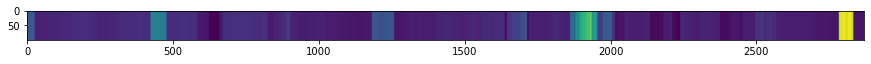

In [594]:
plt.figure(figsize = (15,8))
plt.imshow(cors)
plt.plot()

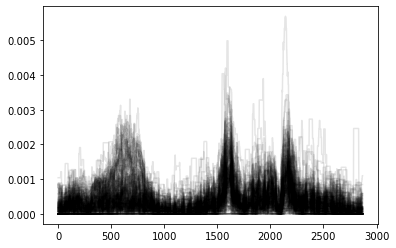

In [595]:
for i in range(distribution.shape[0]):
    plt.plot(list(range(distribution.shape[1])), distribution[i, :], color="black", alpha=0.1)
plt.show()

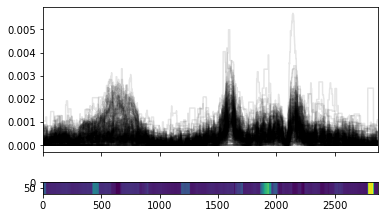

In [596]:
fig = plt.figure()
# set height ratios for subplots
gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1]) 

# the first subplot
ax0 = plt.subplot(gs[0])
# log scale for axis Y of the first subplot
for i in range(distribution.shape[0]):
    ax0.plot(list(range(distribution.shape[1])), distribution[i, :], color="black", alpha=0.1)

# the second subplot
# shared axis X
ax1 = plt.subplot(gs[1], sharex = ax0)
ax1.imshow(cors)
plt.setp(ax0.get_xticklabels(), visible=False)
# remove last tick label for the second subplot
yticks = ax1.yaxis.get_major_ticks()
yticks[-1].label1.set_visible(False)

# put legend on first subplot
# remove vertical gap between subplots
plt.subplots_adjust(hspace=0)
plt.show()